In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomBrightness, Resizing, RandomContrast, RandomZoom, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Data Acquisition

In [ ]:
def readImage(image_path):
    return cv2.imread(image_path, cv2.IMREAD_COLOR)

positive_dir = 'COVID-19/Positif/'
negative_dir = 'COVID-19/Negatif/'

positive_images = [positive_dir + i for i in os.listdir(positive_dir)]
negative_images = [negative_dir + i for i in os.listdir(negative_dir)]

positive_images = [readImage(i) for i in positive_images]
negative_images = [readImage(i) for i in negative_images]

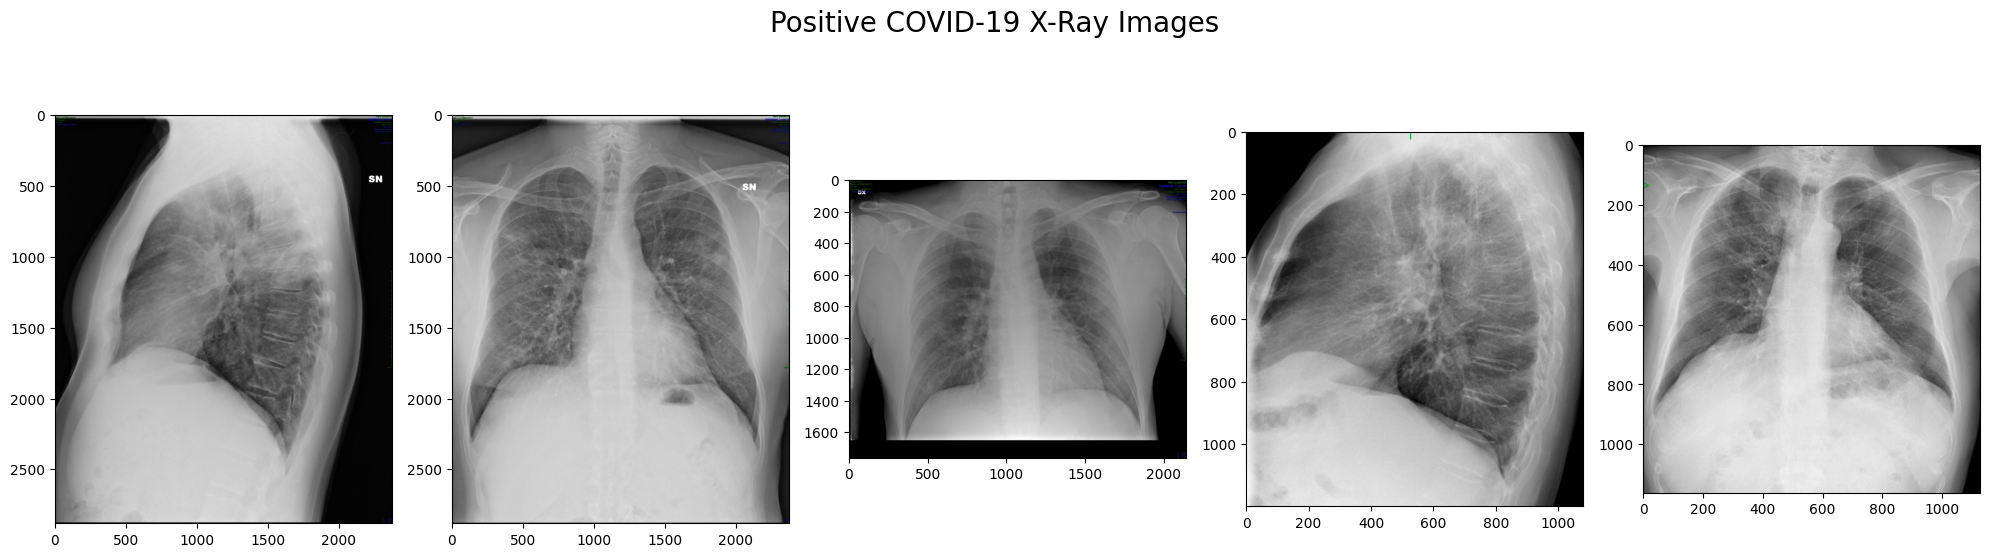

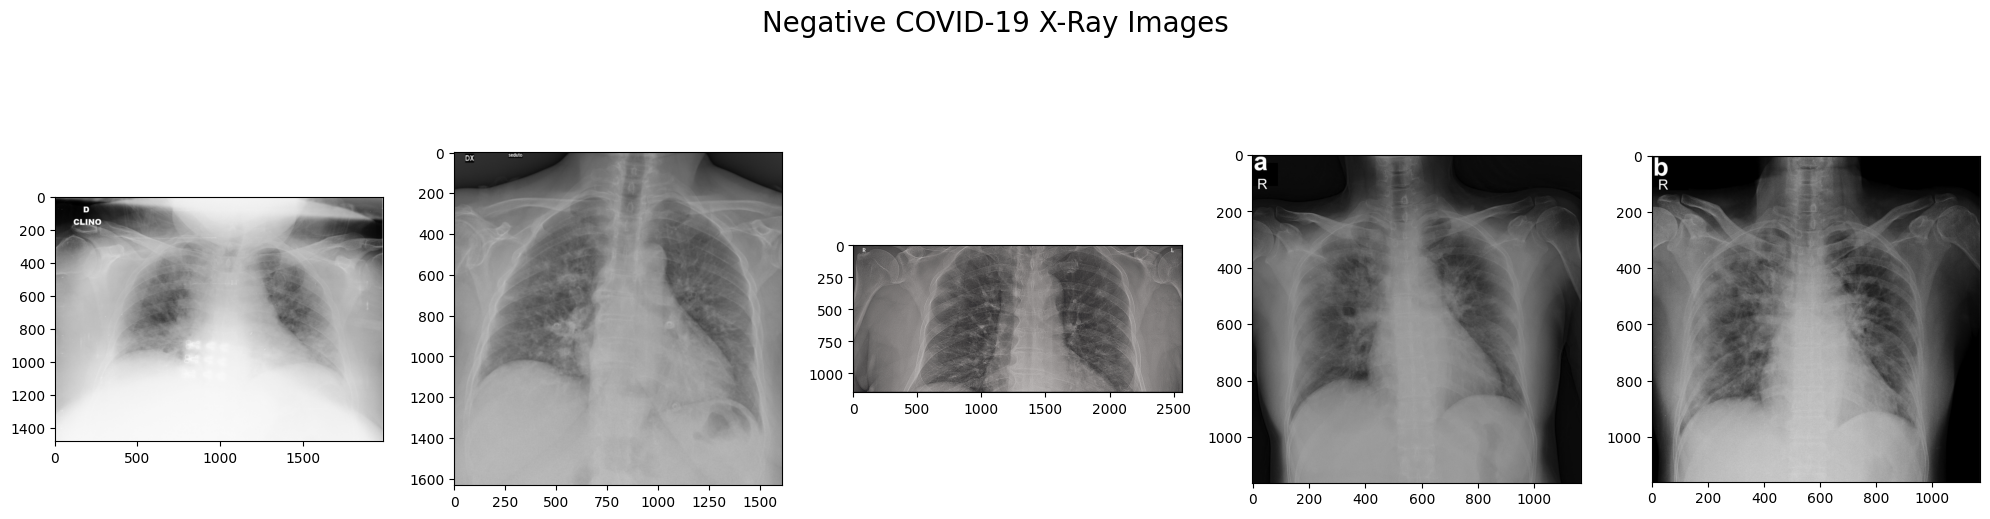

In [ ]:

def plotImages(images, title, n=5):
    fig, ax = plt.subplots(1, n, figsize=(20, 6))
    for i in range(n):
        ax[i].imshow(images[i])
        # ax[i].axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

plotImages(positive_images, 'Positive COVID-19 X-Ray Images')
plotImages(negative_images, 'Negative COVID-19 X-Ray Images')

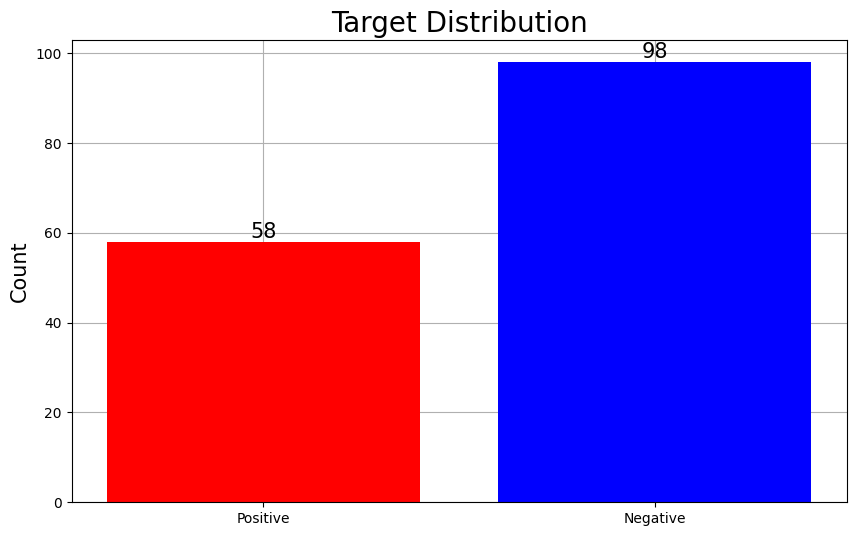

In [ ]:
def showTargetDistribution(data_a, data_b, title):
    plt.figure(figsize=(10, 6))
    plt.bar(['Positive', 'Negative'], [len(data_a), len(data_b)], color=['red', 'blue'])
    plt.ylabel('Count', fontsize=15)
    for i, count in enumerate([len(data_a), len(data_b)]):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=15)
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.title(title, fontsize=20)
    plt.show()

showTargetDistribution(positive_images, negative_images, 'Target Distribution')

In [ ]:
def createDataset(images, label):
    data = []
    for img in images:
        data.append([img, label])
    return data

label_dict = {1: 'Positive', 0: 'Negative'}
label_dict_inv = {v: k for k, v in label_dict.items()}

positive_data = createDataset(positive_images, 'Positive')
negative_data = createDataset(negative_images, 'Negative')

df = pd.DataFrame(positive_data + negative_data, columns=['image', 'label'])
df = df.reset_index(drop=True)
df

,image,label
0,"[[[0, 4, 0], [2, 3, 1], [5, 0, 3], [8, 0, 7], ...",Positive
1,"[[[0, 4, 0], [4, 5, 3], [5, 0, 3], [15, 4, 14]...",Positive
2,"[[[0, 2, 0], [0, 1, 0], [5, 0, 3], [7, 0, 6], ...",Positive
3,"[[[17, 17, 17], [10, 10, 10], [7, 7, 7], [4, 4...",Positive
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Positive
...,...,...
151,"[[[6, 6, 6], [6, 6, 6], [6, 6, 6], [6, 6, 6], ...",Negative
152,"[[[59, 56, 58], [59, 56, 58], [59, 56, 58], [5...",Negative
153,"[[[55, 52, 54], [55, 52, 54], [55, 52, 54], [5...",Negative
154,"[[[59, 56, 58], [59, 56, 58], [59, 56, 58], [5...",Negative


In [ ]:
X = df['image']
y = df['label']

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_tr = pd.DataFrame({'image': X_tr, 'label': y_tr}).reset_index(drop=True)
df_test = pd.DataFrame({'image': X_test, 'label': y_test}).reset_index(drop=True)

# Data Preprocessing

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

data_augmentation = Sequential()
data_augmentation.add(RandomRotation(0.01))
data_augmentation.add(RandomBrightness(factor=0.0001))
data_augmentation.add(RandomContrast(factor=0.01))
data_augmentation.add(RandomZoom(.2, .2))
data_augmentation.add(Resizing(IMG_WIDTH, IMG_HEIGHT))

def getAugmentedImages(image, n=3):
    augmented_images = [image]
    temp = tf.cast(tf.expand_dims(image, 0), tf.float32)
    for i in range(n):
        augmented_image = data_augmentation(temp)
        augmented_images.append(augmented_image[0])
    return augmented_images

def resizeImage(image, width, height):
    return cv2.resize(image, (width, height))

def convertGrayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalizeImage(image):
    return image / 255

def getImages(df):
    images = []
    for image in df['image']:
        images.append(image)
    return images

In [ ]:
df_preprocessed = df_tr.copy()
df_preprocessed['image'] = df_preprocessed['image'].apply(lambda x: resizeImage(x, IMG_WIDTH, IMG_HEIGHT))
# df_preprocessed['image'] = df_preprocessed['image'].apply(lambda x: convertGrayscale(x))
df_preprocessed['image'] = df_preprocessed['image'].apply(lambda x: normalizeImage(x))
# df_preprocessed

In [ ]:
df_preprocessed_test = df_test.copy()
df_preprocessed_test['image'] = df_preprocessed_test['image'].apply(lambda x: resizeImage(x, IMG_WIDTH, IMG_HEIGHT))
# df_preprocessed_test['image'] = df_preprocessed_test['image'].apply(lambda x: convertGrayscale(x))
df_preprocessed_test['image'] = df_preprocessed_test['image'].apply(lambda x: normalizeImage(x))
# df_preprocessed_test

In [ ]:
pos_images = getImages(df_preprocessed[df_preprocessed['label'] == 'Positive'])
neg_images = getImages(df_preprocessed[df_preprocessed['label'] == 'Negative'])

aug_pos_images = []
aug_neg_images = []

for image in pos_images:
    augmented_images = getAugmentedImages(image, n=8)
    aug_pos_images.extend(augmented_images)

for image in neg_images:
    augmented_images = getAugmentedImages(image, n=4)
    aug_neg_images.extend(augmented_images)

df_preprocessed_augmented = pd.DataFrame(createDataset(aug_pos_images, 'Positive') + createDataset(aug_neg_images, 'Negative'), columns=['image', 'label'])
df_preprocessed_augmented = df_preprocessed_augmented.reset_index(drop=True)

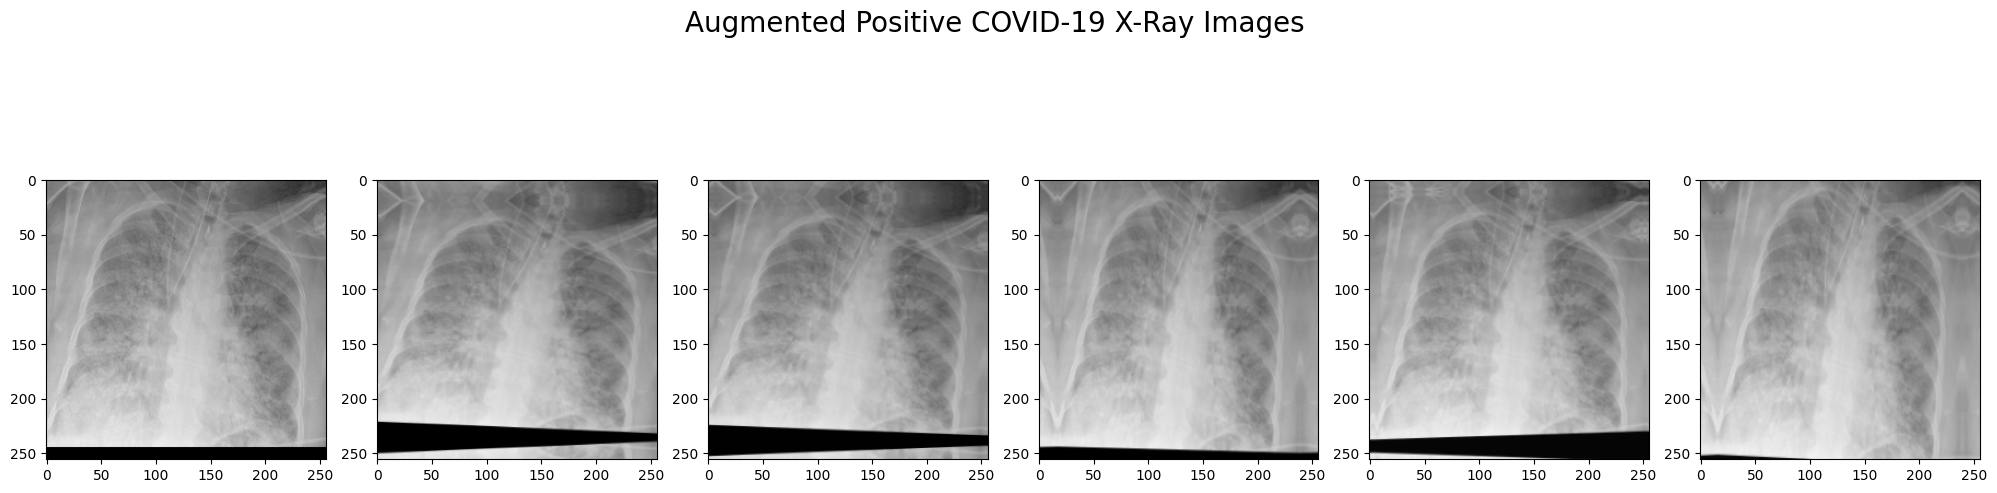

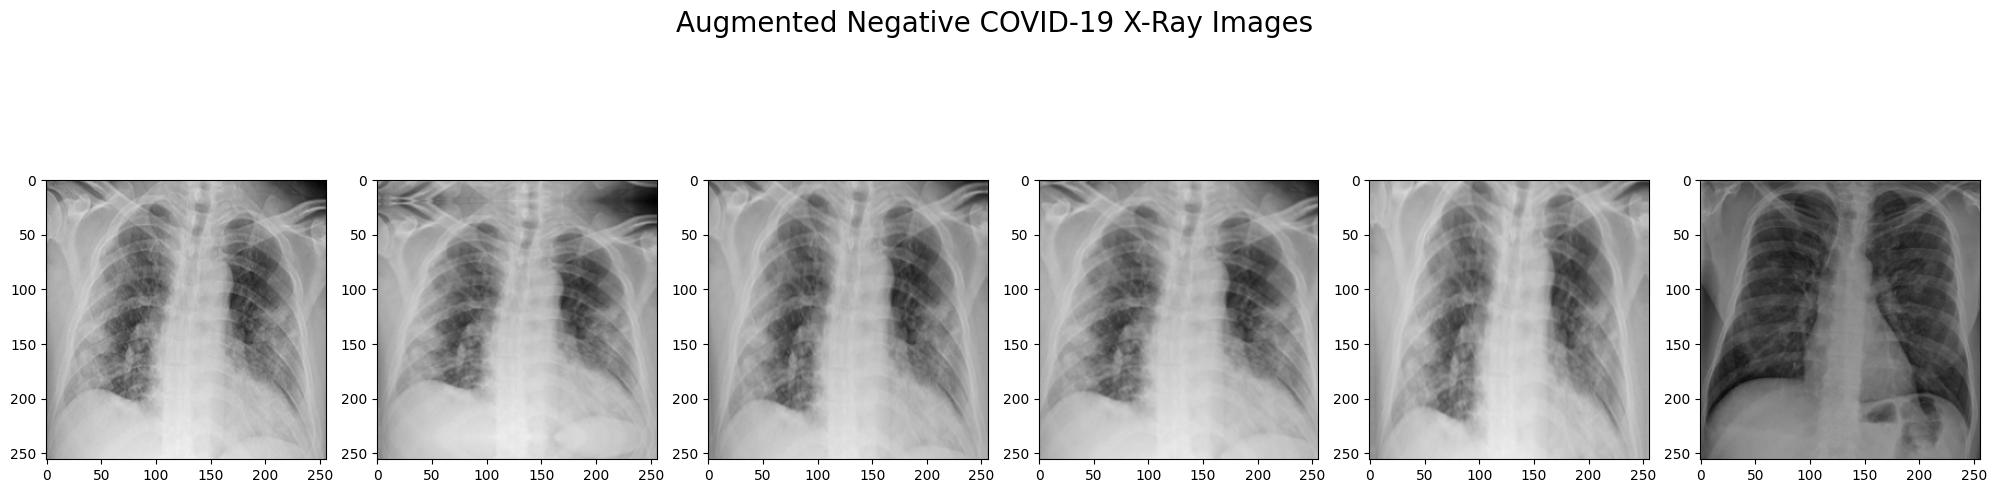

In [ ]:
plotImages(aug_pos_images, 'Augmented Positive COVID-19 X-Ray Images', n=6)
plotImages(aug_neg_images, 'Augmented Negative COVID-19 X-Ray Images', n=6)

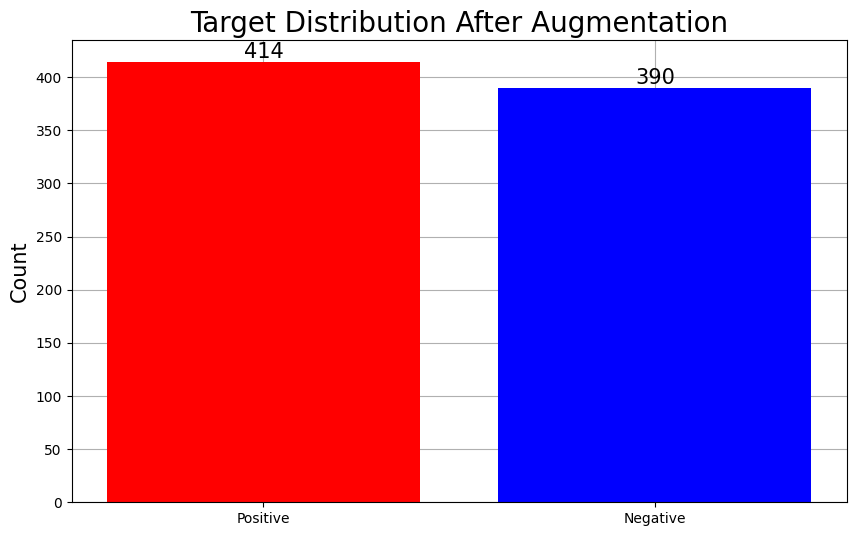

In [ ]:
showTargetDistribution(aug_pos_images, aug_neg_images, 'Target Distribution After Augmentation')

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split

X_tr = np.array(df_preprocessed_augmented['image'].tolist())
y_tr = np.array(df_preprocessed_augmented['label'].apply(lambda x: label_dict_inv[x]).tolist())

X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)
X_test = np.array(df_preprocessed_test['image'].tolist())
y_test = np.array(df_preprocessed_test['label'].apply(lambda x: label_dict_inv[x]).tolist())

In [ ]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu",input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 84, 84, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 82, 82, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 128)       0         
 g2D)                                                 

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100, batch_size=32,
                    callbacks=[model_checkpoint, early_stopping])

# model = tf.keras.models.load_model('best_model.h5')

Epoch 1/100
21/21 [==============================] - 61s 3s/step - loss: 1.1707 - accuracy: 0.5054 - val_loss: 0.6906 - val_accuracy: 0.5031
Epoch 2/100


c:\Users\rhafaelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 59s 3s/step - loss: 0.6922 - accuracy: 0.5179 - val_loss: 0.6923 - val_accuracy: 0.5528
Epoch 3/100
21/21 [==============================] - 61s 3s/step - loss: 0.6937 - accuracy: 0.5474 - val_loss: 0.6907 - val_accuracy: 0.4845
Epoch 4/100
21/21 [==============================] - 63s 3s/step - loss: 0.6830 - accuracy: 0.5583 - val_loss: 0.6673 - val_accuracy: 0.5839
Epoch 5/100
21/21 [==============================] - 62s 3s/step - loss: 0.6447 - accuracy: 0.6159 - val_loss: 0.6631 - val_accuracy: 0.6149
Epoch 6/100
21/21 [==============================] - 63s 3s/step - loss: 0.6180 - accuracy: 0.6392 - val_loss: 0.6522 - val_accuracy: 0.6211
Epoch 7/100
21/21 [==============================] - 65s 3s/step - loss: 0.5781 - accuracy: 0.6703 - val_loss: 0.6360 - val_accuracy: 0.6273
Epoch 8/100
21/21 [==============================] - 63s 3s/step - loss: 0.5419 - accuracy: 0.6890 - val_loss: 0.6312 - val_accuracy: 0.6460
Epoch 9/100
21/21 [======

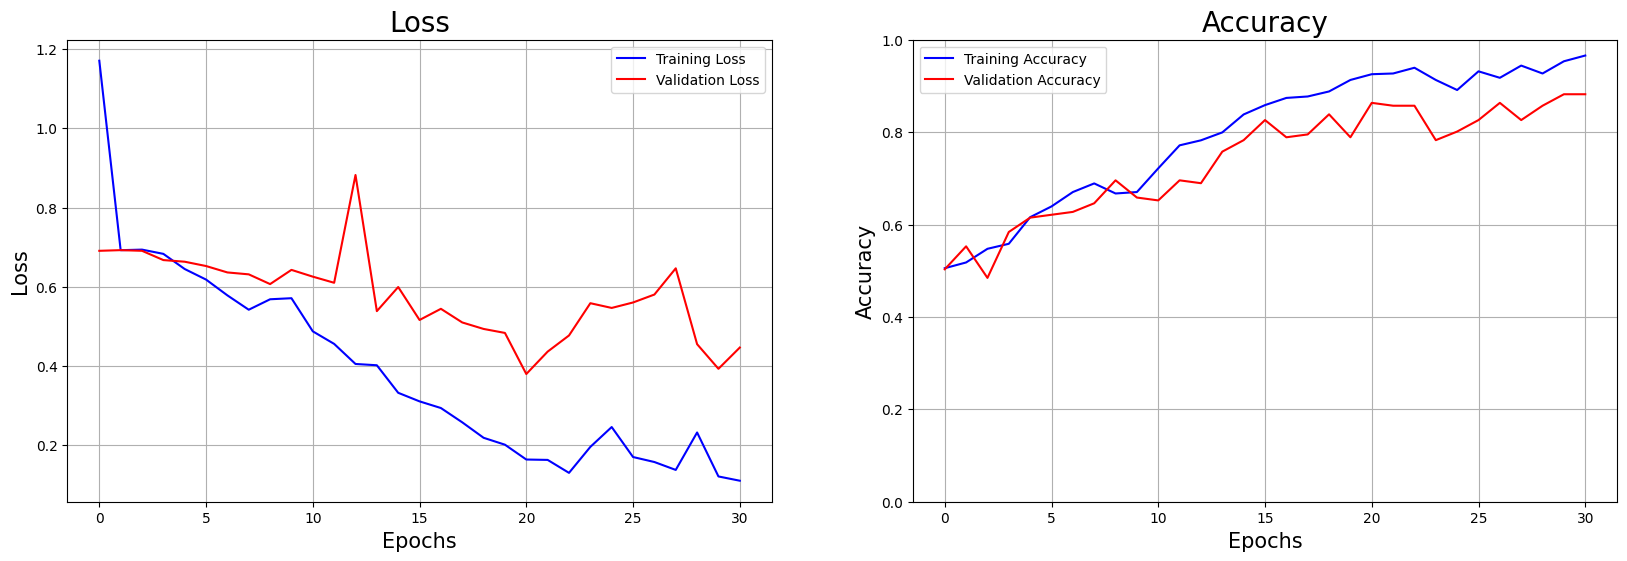

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(history.history['loss'], label='Training Loss', color='blue')
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
# ax[0].set_ylim([0, 1])
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xlabel('Epochs', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)
ax[1].set_ylim([0, 1])
ax[1].legend()
ax[1].grid()

plt.show()

In [ ]:
print('Train Accuracy: ', history.history['accuracy'][-1])
print('Validation Accuracy: ', history.history['val_accuracy'][-1])

Train Accuracy:  0.9657853841781616
Validation Accuracy:  0.8819875717163086


# Evaluation

In [ ]:
model = tf.keras.models.load_model('best_model.h5')

y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5)

1/1 [==============================] - 1s 567ms/step


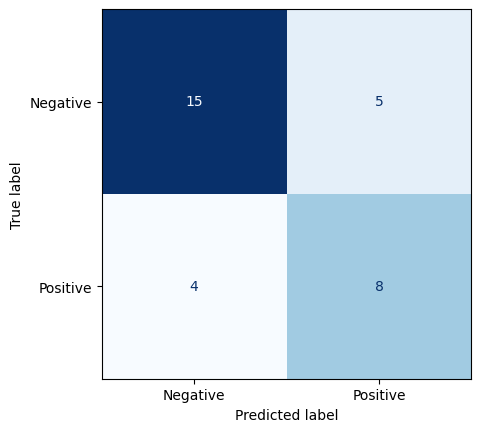

              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77        20
    Positive       0.62      0.67      0.64        12

    accuracy                           0.72        32
   macro avg       0.70      0.71      0.70        32
weighted avg       0.72      0.72      0.72        32



In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', display_labels=['Negative', 'Positive'], colorbar=False)
plt.show()

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))